In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
import pickle
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from utils import timeseries_visualization, load_data, visualize_hist_and_boxplot, visualize_pca
np.random.seed(1)
random.seed(1)


In [2]:
# Load data and compute lagged features
df_lagged = load_data(lagged=True, exclude_ids=True)
# Dropping NaN values
df_lagged = df_lagged.dropna()
#df_lagged


In [3]:
df_lagged

,timestamp,back_x,back_y,back_z,thigh_x,thigh_y,thigh_z,label,subject_id,back_x_lag_1,...,thigh_y_lag_1,thigh_y_lag_2,thigh_y_lag_3,thigh_y_lag_4,thigh_y_lag_5,thigh_z_lag_1,thigh_z_lag_2,thigh_z_lag_3,thigh_z_lag_4,thigh_z_lag_5
5,2021-03-24 14:42:03.940,-0.988770,-0.026123,0.157227,-0.984863,-0.042725,-0.032715,6,501,-0.972412,...,-0.023682,-0.046143,-0.080566,-0.121582,-0.112061,-0.026611,-0.050781,-0.067139,-0.051758,-0.048096
6,2021-03-24 14:42:03.960,-1.001953,-0.016113,0.162109,-0.992920,-0.075439,-0.024170,6,501,-0.988770,...,-0.042725,-0.023682,-0.046143,-0.080566,-0.121582,-0.032715,-0.026611,-0.050781,-0.067139,-0.051758
7,2021-03-24 14:42:03.980,-1.000488,-0.035400,0.191406,-0.996338,-0.072754,-0.013428,6,501,-1.001953,...,-0.075439,-0.042725,-0.023682,-0.046143,-0.080566,-0.024170,-0.032715,-0.026611,-0.050781,-0.067139
8,2021-03-24 14:42:04.000,-0.996826,-0.056152,0.187500,-0.974609,-0.060303,-0.015625,6,501,-1.000488,...,-0.072754,-0.075439,-0.042725,-0.023682,-0.046143,-0.013428,-0.024170,-0.032715,-0.026611,-0.050781
9,2021-03-24 14:42:04.019,-0.978027,-0.083252,0.187500,-0.966797,-0.062500,-0.015625,6,501,-0.996826,...,-0.060303,-0.072754,-0.075439,-0.042725,-0.023682,-0.015625,-0.013428,-0.024170,-0.032715,-0.026611
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2183996,2021-06-11 11:13:14.098,-0.960693,-0.199951,-0.330566,-0.977051,0.006104,-0.246826,1,518,-0.961914,...,-0.120850,-0.133545,0.348633,0.621826,0.710693,-0.262207,-0.312744,-0.231445,-0.003906,0.032227
2183997,2021-06-11 11:13:14.118,-0.942627,-0.210205,-0.331543,-0.969482,0.004883,-0.231445,1,518,-0.960693,...,0.006104,-0.120850,-0.133545,0.348633,0.621826,-0.246826,-0.262207,-0.312744,-0.231445,-0.003906
2183998,2021-06-11 11:13:14.138,-0.907227,-0.190918,-0.320312,-1.048096,0.067627,-0.234375,1,518,-0.942627,...,0.004883,0.006104,-0.120850,-0.133545,0.348633,-0.231445,-0.246826,-0.262207,-0.312744,-0.231445
2183999,2021-06-11 11:13:14.159,-0.883057,-0.156982,-0.311279,-1.007080,0.063965,-0.248047,1,518,-0.907227,...,0.067627,0.004883,0.006104,-0.120850,-0.133545,-0.234375,-0.231445,-0.246826,-0.262207,-0.312744


In [4]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Normalize the numerical columns (excluding the 'subject_id' column)
#numerical_columns = [col for col in df_lagged.columns if col != 'subject_id' and col!='label' and col!='timestamp']
#df_lagged[numerical_columns] = scaler.fit_transform(df_lagged[numerical_columns])


numerical_columns = [col for col in df_lagged.columns if col != 'subject_id' and col!='label' and col!='timestamp']
df_lagged[numerical_columns] = scaler.fit_transform(df_lagged[numerical_columns])




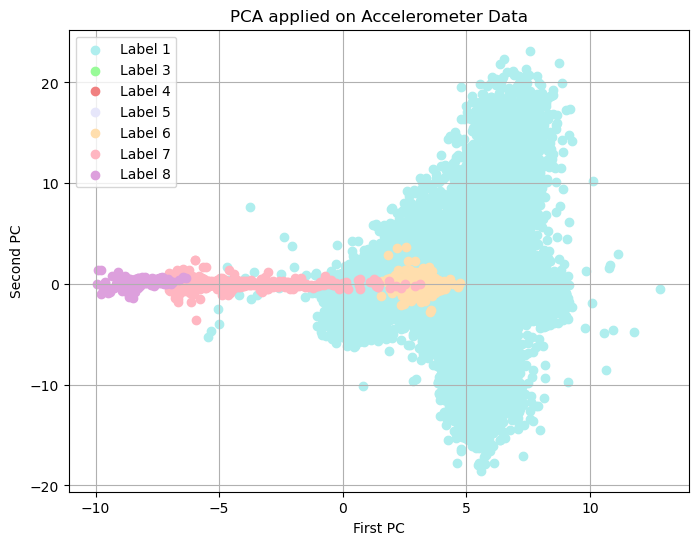

In [5]:
visualize_pca(df_lagged, 509)

In [6]:

pca = PCA(n_components=11)
exclude_columns = ['timestamp', 'subject_id', 'label']
df_lagged_PC = df_lagged.drop(exclude_columns, axis=1)
components = pca.fit_transform(df_lagged_PC)
labels = {
    str(i): f"PC {i+1} ({var:.1f}%)"
    for i, var in enumerate(pca.explained_variance_ratio_ * 100)
}



In [7]:
print(labels)

{'0': 'PC 1 (44.9%)', '1': 'PC 2 (15.9%)', '2': 'PC 3 (8.5%)', '3': 'PC 4 (5.7%)', '4': 'PC 5 (4.4%)', '5': 'PC 6 (3.5%)', '6': 'PC 7 (3.1%)', '7': 'PC 8 (2.2%)', '8': 'PC 9 (2.0%)', '9': 'PC 10 (1.6%)', '10': 'PC 11 (1.4%)'}


In [8]:

X = components
y = df_lagged['label'].values

print(X.shape)
print(y.shape)

(2183911, 11)
(2183911,)


In [10]:

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 1)

In [11]:
# Credit: chatGPT was partially employed for coding

# Values of n_neighbors to be tested
n_neighbors_values = range(3,10)

# Create a stratified 10-fold cross-validation object
stratified_kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=1)

# Dictionary to store F1 scores for each n_neighbors value
f1_scores = {}
predictions = {key: [] for key in n_neighbors_values}
actual = {key: [] for key in n_neighbors_values}

for n_neighbors in n_neighbors_values:
    print(f'Tuning hyperparameter n_neighbors: Current Value {n_neighbors}')
    # Lists to store cross-validation results for the current n_neighbors value
    cv_f1_scores = []

    # Perform stratified 10-fold cross-validation
    # TODO: change this with train and validation split
    for train_index, test_index in stratified_kfold.split(X_train, y_train):
        
        # Define the KNN classifier 
        knn = KNeighborsClassifier(n_neighbors=n_neighbors)  
        
        # Get training and testing folds
        X_train_fold, X_test_fold = X[train_index], X[test_index]
        y_train_fold, y_test_fold = y[train_index], y[test_index]

        # Fit the KNN classifier 
        knn.fit(X_train_fold, y_train_fold)

        # Make predictions on the validation data
        y_pred = knn.predict(X_test_fold)
        actual[n_neighbors].append(y_test_fold)
        predictions[n_neighbors].append(y_pred)

        # Calculate and store the F1 score for this fold
        f1 = f1_score(y_test_fold, y_pred, average='micro')  
        print('Score on test is', f1)
        cv_f1_scores.append(f1)

    # Calculate and store the mean F1 score for the current n_neighbors value
    f1_scores[n_neighbors] = np.mean(cv_f1_scores)

# Find the n_neighbors value with the highest mean F1 score
best_n_neighbors = max(f1_scores, key=f1_scores.get)
best_mean_f1 = f1_scores[best_n_neighbors]

print("Mean F1 Scores:")
for n_neighbors, mean_f1 in f1_scores.items():
    print(f"n_neighbors={n_neighbors}: Mean F1 Score={mean_f1}")

print(f"Best n_neighbors value: {best_n_neighbors}")
print(f"Best Mean F1 Score: {best_mean_f1}")


Tuning hyperparameter n_neighbors: Current Value 3
Score on test is 0.9814089179499155
Score on test is 0.9818278912592552
Score on test is 0.9816785032350234
Tuning hyperparameter n_neighbors: Current Value 4
Score on test is 0.9819704108685797
Score on test is 0.98252331826861
Score on test is 0.9822073711828784
Tuning hyperparameter n_neighbors: Current Value 5
Score on test is 0.9787319532398313
Score on test is 0.9791869857274338
Score on test is 0.9788452820858002
Tuning hyperparameter n_neighbors: Current Value 6
Score on test is 0.9796128274516807
Score on test is 0.9800026099976648
Score on test is 0.9796849458082064
Tuning hyperparameter n_neighbors: Current Value 7
Score on test is 0.9773359479099414
Score on test is 0.9776518949956728
Score on test is 0.9773599873621166
Tuning hyperparameter n_neighbors: Current Value 8
Score on test is 0.9780622827863785
Score on test is 0.9784314600876409
Score on test is 0.9780519801640177
Tuning hyperparameter n_neighbors: Current Value

Text(0, 0.5, 'F-score')

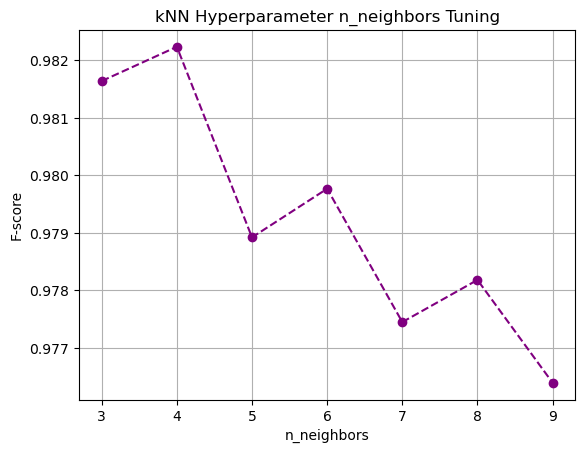

In [12]:
f1_list = [ f1_scores[i] for i in range(3,10)]

#plt.scatter(n_neighbors_values,f1_list, color='purple', marker='x')
plt.plot(n_neighbors_values, f1_list, '--o', color='purple')
plt.grid()
plt.title('kNN Hyperparameter n_neighbors Tuning')
plt.xlabel('n_neighbors')
plt.ylabel('F-score')

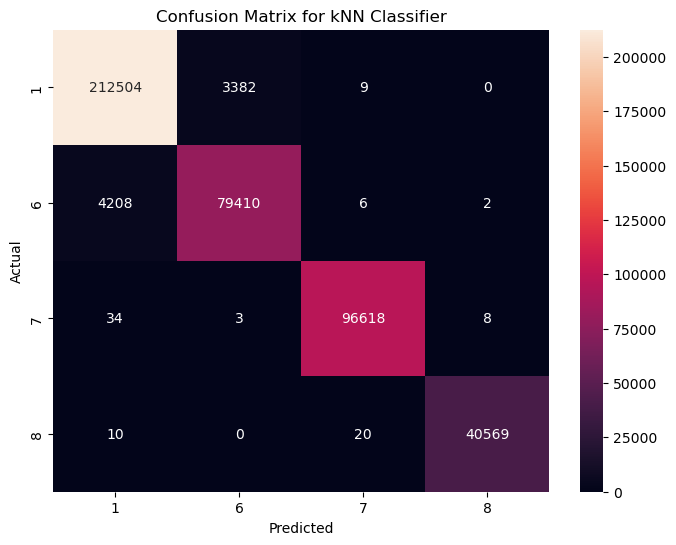

In [13]:

# Create a KNN classifier with the optimal parameters
knn_classifier = KNeighborsClassifier(n_neighbors=best_n_neighbors)

# Fit the classifier on the training data
knn_classifier.fit(X_train, y_train)

# Make predictions on the training and test sets
#y_train_pred = knn_classifier.predict(X_train)
y_test_pred = knn_classifier.predict(X_test)


# Define a function to plot the confusion matrix
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d",  xticklabels=np.unique(y_true), yticklabels=np.unique(y_true))
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Plot the confusion matrix for the test set

# TODO: change this to compare the predictions and the labels for independent test set
plot_confusion_matrix(y_test, y_test_pred, "Confusion Matrix for kNN Classifier")

y_proba = knn_classifier.predict_proba(X_test)




In [14]:
# TODO: change this for independent test set
sk_report = classification_report(
    digits=6,
    y_true=y_test, 
    y_pred=y_test_pred)
print(sk_report)

              precision    recall  f1-score   support

           1   0.980383  0.984293  0.982334    215895
           6   0.959116  0.949585  0.954327     83626
           7   0.999638  0.999534  0.999586     96663
           8   0.999754  0.999261  0.999507     40599

    accuracy                       0.982412    436783
   macro avg   0.984723  0.983168  0.983939    436783
weighted avg   0.982373  0.982412  0.982386    436783



In [15]:
# Save the predictions
with open('f_scores_with_feature_eng.pkl', 'wb') as file:
    data_to_store = f1_list
    pickle.dump(data_to_store, file)

In [16]:
# Save the predictions
with open('predictions_kNN_eng.pkl', 'wb') as file:
    data_to_store = y_proba
    pickle.dump(data_to_store, file)